# Import packages

In [1]:
import sys
import numpy as np
import pylab as pl
from numpy import fft
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
import datetime
from dateutil.relativedelta import relativedelta

# FFT function
Get a mixed harmonics by n_harm harmonics to fit the date_0 to date_1 stock and predict date_1 to date_2,
df = dataframe

In [2]:
def FFT(n_harm,stock,date_0,date_1,date_2):
    data = yf.Ticker(stock).history(start=date_0, end=date_1)
    price = data['Close']
    x = np.array(price)
    data2 = yf.Ticker(stock).history(start=date_0, end=date_2)
    price2 = data2['Close']
    x2 = np.array(price2)
    n_predict = price2.size - price.size
    n_x = x.size
    t = np.arange(0, n_x)
    p = np.polyfit(t, x, 1)     # find linear trend in x
    x_notrend = x - p[0] * t    # detrended x
    x_freqdom = fft.fft(x_notrend,n = n_x)        
    f = fft.fftfreq(n_x)
    indexes = list(range(n_x))      # frequencies
    # sort method 1
    # indexes.sort(key = lambda i: np.absolute(f[i]))     # sort indexes by frequency, lower -> higher
    # sort method 2
    indexes.sort(key=lambda i: np.absolute(x_freqdom[i]))       # sort indexes by amplitudes, lower -> higher 
    indexes.reverse()       # sort indexes by amplitudes, higher -> lower 
    t = np.arange(0, n_x + n_predict)
    restored_sig = np.zeros(t.size)
    count = 0
    for i in indexes[1:1 + n_harm * 2]:
        if (count <= 100 or count >= (n_harm * 2 -2)): 
            if(count % 2 == 0):
                ampli = np.absolute(x_freqdom[i]) / n_x     # amplitude
                phase = np.angle(x_freqdom[i])      # phase
                signal = ampli * np.cos(2 * np.pi * f[i] * t + phase)
                restored_sig += signal
            count += 1
    signal = restored_sig
    df = pd.DataFrame()
    df.index = price2.index
    df['Close'] = signal
    # df = df.drop(df[df.index < date_1].index)
    return df

In [3]:
# FFT(20,"^GSPC",'2021-01-01','2022-01-01','2022-02-01')

# peak_valleys frnction

In [4]:
def peak_valleys(pv_range,data):
    pd.options.mode.chained_assignment = None
    pv = data['Close']
    data['peaks'] = pd.Series(dtype='float64') 
    data['valleys'] = pd.Series(dtype='float64') 
    peaks = data['peaks']
    valleys = data['valleys']
    for idx in range(0, len(pv)):
        if pv[idx] == pv.iloc[idx-pv_range:idx+pv_range].max():
            peaks.iloc[idx] = pv[idx]
        if pv[idx] == pv.iloc[idx-pv_range:idx+pv_range].min():
            valleys.iloc[idx] = pv[idx]
    return peaks,valleys

In [5]:
# data = yf.Ticker("^GSPC").history(start='2021-01-01', end='2022-01-01')
# pv_range = 2
# peak_valleys(pv_range,data)

In [6]:
def peak_valleys_delay(pv_1,pv_2):
    import datetime
    df_p_1 = pd.DataFrame()
    df_p_1['peaks_1'] = pv_1['peaks']
    df_p_1 = df_p_1.dropna(how='all') 
    li_peak_1 = list(df_p_1['peaks_1'].index)
    df_p_2 = pd.DataFrame()
    df_p_2['peaks_2'] = pv_2['peaks']
    df_p_2 = df_p_2.dropna(how='all') 
    li_peak_2 = list(df_p_2['peaks_2'].index)
    li_peak = []
    for i in range(0,len(li_peak_2)): 
        temp = []
        temp_abs = []
        temp2 = []
        for j in range(0,len(li_peak_1)): 
            temp.append((li_peak_1[j] - li_peak_2[i]).days)
            temp_abs.append(abs(li_peak_1[j] - li_peak_2[i]).days)
        for k in range(0,len(temp_abs)):
            if temp_abs[k] == min(temp_abs) : 
                temp2 = round(temp[k])
        li_peak.append(temp2)
    df_p_2['delay'] = li_peak
    df_v_1 = pd.DataFrame()
    df_v_1['valleys_1'] = pv_1['valleys']
    df_v_1 = df_v_1.dropna(how='all') 
    li_valley_1 = list(df_v_1['valleys_1'].index)
    df_v_2 = pd.DataFrame()
    df_v_2['valleys_2'] = pv_2['valleys']
    df_v_2 = df_v_2.dropna(how='all') 
    li_valley_2 = list(df_v_2['valleys_2'].index)
    li_valley = []
    for i in range(0,len(li_valley_2)): 
        temp = []
        temp_abs = []
        temp2 = []
        for j in range(0,len(li_valley_1)): 
            temp.append((li_valley_1[j] - li_valley_2[i]).days)
            temp_abs.append(abs(li_valley_1[j] - li_valley_2[i]).days)
        for k in range(0,len(temp_abs)):
            if temp_abs[k] == min(temp_abs) : 
                temp2 = round(temp[k])
        li_valley.append(temp2)
    df_v_2['delay'] = li_valley
    return df_p_2['delay'],df_v_2['delay']

In [7]:
# data = yf.Ticker("^GSPC").history(start='2021-01-01', end='2022-01-01')
# data2 = FFT(20,"^GSPC",'2021-01-01','2021-06-01','2022-01-01')
# pv_range = 2
# data2['peaks'] = peak_valleys(pv_range,data2)[0]
# data2['valleys'] = peak_valleys(pv_range,data2)[1]
# data['peaks'] = peak_valleys(pv_range,data)[0]
# data['valleys'] = peak_valleys(pv_range,data)[1]
# data2['peaks_delay'] = peak_valleys_delay(data,data2)[0]
# data2['valleys_delay'] = peak_valleys_delay(data,data2)[1]
# data2

In [8]:
def draw_plot_1(data,df):
    fig, axes = plt.subplots(2, 1, figsize=(15, 8))
    axes[0].plot(data.index, data['Close'], c='gray',label='data',linewidth=3)
    axes[1].plot(df.index, df['Close'],c='gray' ,label='Predict',linewidth=3)
    try :
        axes[0].plot(data.index,data['peaks'],'^',c='royalblue',label='peaks')
        axes[0].plot(data.index,data['valleys'],'v',c='orangered',label='valleys')
        axes[1].plot(df.index , df['peaks'],'^',c='royalblue',label='peaks')
        axes[1].plot(df.index , df['valleys'],'v',c='orangered',label='valleys')
    except:
        pass
    try:
        for i, label in enumerate(df['peaks_delay']):
            axes[1].annotate(label, (df['peaks'].index[i],  df['peaks'][i]),fontsize=14)
        for i, label in enumerate(df['valleys_delay']):
            axes[1].annotate(label, (df['valleys'].index[i],  df['valleys'][i]),fontsize=14)
    except:
        pass
    axes[0].set_ylabel("price", fontsize=14)
    axes[0].grid(True)
    axes[1].grid(True)
    axes[1].set_ylabel("amplitude", fontsize=14)
    axes[0].legend()
    axes[1].legend()
    plt.show()
    return 

# Score function
三種type計算fit_score，得score_p,score_v。 
fit_score為score_p及score_v取平均。
best_fit為取最接近零的score之harmonic。
slide_score為預測之第一個轉折delay。
final_score為slide_score取絕對值後取平均。

In [9]:
def fit_score(df,type):
    if type == 'mean':
        df_temp = df.drop(df[df['peaks_delay'].isna()].index)
        score_p = df_temp['peaks_delay'].mean()
        df_temp = df.drop(df[df['valleys_delay'].isna()].index)
        score_v = df_temp['valleys_delay'].mean()
    elif type == 'abs':
        df_temp = df.drop(df[df['peaks_delay'].isna()].index)
        score_p = abs(df['peaks_delay']).mean()
        df_temp = df.drop(df[df['valleys_delay'].isna()].index)
        score_v = abs(df['valleys_delay']).mean()
    else :
        return 'wrong type'
    return score_p,score_v

In [10]:
# data = yf.Ticker("^GSPC").history(start='2020-01-01', end='2021-02-01')
# data2 = FFT(19,"^GSPC",'2020-01-01','2021-01-01','2021-02-01')
# pv_range = 2
# data2['peaks'] = peak_valleys(pv_range,data2)[0]
# data2['valleys'] = peak_valleys(pv_range,data2)[1]
# data['peaks'] = peak_valleys(pv_range,data)[0]
# data['valleys'] = peak_valleys(pv_range,data)[1]
# data2['peaks_delay'] = peak_valleys_delay(data[data.index <= '2021-01-01'],data2[data2.index <= '2021-01-01'])[0]
# data2['valleys_delay'] = peak_valleys_delay(data[data.index <= '2021-01-01'],data2[data2.index <= '2021-01-01'])[1]
# print('abs =' ,fit_score(data2,'abs'))
# print('positive =',fit_score(data2,'positive'))
# print('mean =',fit_score(data2,'mean'))

In [11]:
# data2['peaks_delay'] = peak_valleys_delay(data,data2)[0]
# data2['valleys_delay'] = peak_valleys_delay(data,data2)[1]
# draw_plot_1(data,data2)

In [31]:
def get_first_delay(df):
    df2 = pd.DataFrame()
    df2['peaks_delay'] = df['peaks_delay']
    df2['valleys_delay'] = df['valleys_delay']
    df2 = df2.dropna(how='all')
    if np.isnan(df2['peaks_delay'].iloc[0]) == False :
        Date = df2['peaks_delay'].index[0]
        delay = df2['peaks_delay'].iloc[0]
        pv = 'peaks'
    else :
        Date = df2['valleys_delay'].index[0]
        delay = df2['valleys_delay'].iloc[0]
        pv = 'valleys'
    # Date = datetime.datetime.strftime(Date,'%Y-%m-%d')
    return Date,delay,pv

In [13]:
# data = yf.Ticker("^GSPC").history(start='2020-01-01', end='2021-01-01')
# data2 = FFT(20,"^GSPC",'2020-01-01','2021-01-01','2021-02-01')
# pv_range = 2
# data2['peaks'] = peak_valleys(pv_range,data2)[0]
# data2['valleys'] = peak_valleys(pv_range,data2)[1]
# data['peaks'] = peak_valleys(pv_range,data)[0]
# data['valleys'] = peak_valleys(pv_range,data)[1]
# data2['peaks_delay'] = peak_valleys_delay(data[data.index <= '2021-01-01'],data2[data2.index <= '2021-01-01'])[0]
# data2['valleys_delay'] = peak_valleys_delay(data[data.index <= '2021-01-01'],data2[data2.index <= '2021-01-01'])[1]
# get_first_delay(data2)

(Timestamp('2020-01-15 00:00:00'), 2.0, 'peaks')

In [14]:
def main_function_1(stock,date_0,date_1,date_2,n_harm,pv_range,type):
    data = yf.Ticker(stock).history(start=date_0, end=date_2)
    data['peaks'] = peak_valleys(pv_range,data)[0]
    data['valleys'] = peak_valleys(pv_range,data)[1]
    df = FFT(n_harm,stock,date_0,date_1,date_2)
    df['peaks'] = peak_valleys(pv_range,df)[0]
    df['valleys'] = peak_valleys(pv_range,df)[1]
    df['peaks_delay'] = peak_valleys_delay(data[data.index <= date_1],df[df.index <= date_1])[0]
    df['valleys_delay'] = peak_valleys_delay(data[data.index <= date_1],df[df.index <= date_1])[1]
    score = fit_score(df,type) 
    score = (score[0] + score[1])/2
    df['peaks_delay'] = peak_valleys_delay(data,df)[0]
    df['valleys_delay'] = peak_valleys_delay(data,df)[1]
    return data,df,score

In [15]:
# a = main_function_1("^GSPC",'2021-01-01','2022-01-01','2022-02-01',20,2,'abs')
# data = a[0]
# df = a[1]
# score = a[2]
# draw_plot_1(data,df)
# print(score)

In [16]:
def main_function_slide(stock,date_start,data_range,predict_range,n_harm,pv_range,n_slide):
    date_start = datetime.datetime.strptime(date_start, '%Y-%m-%d')
    date_0 = date_start + relativedelta(months=-data_range)
    df = pd.DataFrame()
    data = pd.DataFrame()
    fig, axes = plt.subplots(2, 1, figsize=(15, 8))
    for i in range(n_slide) :
        date_1 = date_0 + relativedelta(months=+data_range)
        date_2 = date_1 + relativedelta(months=+predict_range)
        temp = FFT(n_harm,stock,date_0,date_1,date_2)
        temp = temp.drop(temp[temp.index < date_1].index)
        axes[1].plot(temp.index, temp['Close'], label='Predict',linewidth=3)
        temp['peaks'] = peak_valleys(pv_range,temp)[0]
        temp['valleys'] = peak_valleys(pv_range,temp)[1]
        data_temp = yf.Ticker(stock).history(start=date_1, end=date_2)
        axes[0].plot(data_temp.index, data_temp['Close'], linewidth=3, label='Test_data')
        data_temp['peaks'] = peak_valleys(pv_range,data_temp)[0]
        data_temp['valleys'] = peak_valleys(pv_range,data_temp)[1]
        temp['peaks_delay'] = peak_valleys_delay(data_temp,temp)[0]
        temp['valleys_delay'] = peak_valleys_delay(data_temp,temp)[1]
        axes[0].plot(data_temp.index,data_temp['peaks'],'^',c='royalblue',label='peaks')
        axes[0].plot(data_temp.index,data_temp['valleys'],'v',c='orangered',label='valleys')
        axes[1].plot(temp.index , temp['peaks'],'^',c='royalblue',label='peaks')
        axes[1].plot(temp.index , temp['valleys'],'v',c='orangered',label='valleys')
        df = pd.concat([df,temp])
        data = pd.concat([data,data_temp])
        date_0 = date_0 + relativedelta(months=+1)
    for i, label in enumerate(df['peaks_delay']):
            axes[1].annotate(label, (df['peaks'].index[i],  df['peaks'][i]),fontsize=14)
    for i, label in enumerate(df['valleys_delay']):
        axes[1].annotate(label, (df['valleys'].index[i],  df['valleys'][i]),fontsize=14)
    axes[0].set_ylabel("price", fontsize=14)
    axes[0].grid(True)
    axes[1].grid(True)
    axes[1].set_ylabel("amplitude", fontsize=14)
    plt.show()
    return data,df

In [17]:
# a = main_function_slide("^GSPC",'2021-01-01',12,1,20,2,12)
# data = a[0]
# df = a[1]
# print('abs =' ,fit_score(df,'abs'))
# print('positive =',fit_score(df,'positive'))
# print('mean =',fit_score(df,'mean'))

In [18]:
def main_function_1_fit_score(stock,date_0,date_1,date_2,n_harm_0,n_harm_1,pv_range,type):
    score = pd.Series(dtype='float64')
    df = pd.Series(dtype='float64')
    for i in range(n_harm_0,n_harm_1+1):
        temp = main_function_1(stock,date_0,date_1,date_2,i,pv_range,type)
        score = pd.concat([score,pd.Series(temp[2])])
    # print(df)
    score = score.reset_index(drop = True)
    score = score.abs()
    best_fit = score.idxmin() + n_harm_0
    temp_2 = main_function_1(stock,date_0,date_1,date_2,best_fit,pv_range,type)
    data,df,score = temp_2
    return data,df,score,best_fit

In [19]:
# a = main_function_1_fit_score("^GSPC",'2021-06-01','2022-07-01','2022-02-01',15,17,2,'mean')
# a

In [20]:
def main_function_slide_fit_score(stock,date_start,data_range,predict_range,n_harm_0,n_harm_1,pv_range,n_slide,type):
    date_start = datetime.datetime.strptime(date_start, '%Y-%m-%d')
    date_0 = date_start + relativedelta(months=-data_range)
    df = pd.DataFrame()
    data = pd.DataFrame()
    fit_score = []
    best_fit = []
    slide_score = []
    fig, axes = plt.subplots(2, 1, figsize=(15, 8))
    for i in range(n_slide) :
        date_1 = date_0 + relativedelta(months=+data_range)
        date_2 = date_1 + relativedelta(months=+predict_range)
        data_drop,temp,score_temp,best_fit_temp = main_function_1_fit_score(stock,date_0,date_1,date_2,n_harm_0,n_harm_1,2,type)
        fit_score.append(round(score_temp,2))
        best_fit.append(best_fit_temp)
        temp = temp.drop(temp[temp.index < date_1].index)
        axes[1].plot(temp.index, temp['Close'], label='Predict',linewidth=3)
        temp['peaks'] = peak_valleys(pv_range,temp)[0]
        temp['valleys'] = peak_valleys(pv_range,temp)[1]
        data_temp = yf.Ticker(stock).history(start=date_1, end=date_2)
        axes[0].plot(data_temp.index, data_temp['Close'], linewidth=3, label='Test_data')
        data_temp['peaks'] = peak_valleys(pv_range,data_temp)[0]
        data_temp['valleys'] = peak_valleys(pv_range,data_temp)[1]
        temp['peaks_delay'] = peak_valleys_delay(data_temp,temp)[0]
        temp['valleys_delay'] = peak_valleys_delay(data_temp,temp)[1]
        df_temp_score = pd.concat([temp['peaks_delay'],temp['valleys_delay']])
        try:
            slide_score.append(df_temp_score.dropna()[0])
        except:
            pass
        axes[0].plot(data_temp.index,data_temp['peaks'],'^',c='royalblue',label='peaks')
        axes[0].plot(data_temp.index,data_temp['valleys'],'v',c='orangered',label='valleys')
        axes[1].plot(temp.index , temp['peaks'],'^',c='royalblue',label='peaks')
        axes[1].plot(temp.index , temp['valleys'],'v',c='orangered',label='valleys')
        df = pd.concat([df,temp])
        data = pd.concat([data,data_temp])
        date_0 = date_0 + relativedelta(months=+predict_range)
    for i, label in enumerate(df['peaks_delay']):
            axes[1].annotate(label, (df['peaks'].index[i],  df['peaks'][i]),fontsize=14)
    for i, label in enumerate(df['valleys_delay']):
        axes[1].annotate(label, (df['valleys'].index[i],  df['valleys'][i]),fontsize=14)
    axes[0].set_ylabel("price", fontsize=14)
    axes[0].grid(True)
    axes[1].grid(True)
    axes[1].set_ylabel("amplitude", fontsize=14)
    final_score =  round(sum([abs(ele) for ele in slide_score]) / len(slide_score) ,2)
    plt.show()
    return data,df,fit_score,best_fit,final_score

In [21]:
# slide_mean = main_function_slide_fit_score("^GSPC",'2021-01-01',12,1,10,11,2,1,'mean')
# print(slide_mean[2])
# print(slide_mean[3])
# print(slide_mean[4])

In [22]:
def main_function_slide_fit_score_slide_range(stock,date_start,data_range,slide_range,n_slide,pv_range,n_harm_0,n_harm_1,type):
    predict_range = data_range
    date_start = datetime.datetime.strptime(date_start, '%Y-%m-%d')
    date_0 = date_start + relativedelta(months=-data_range)
    df = pd.DataFrame()
    data = pd.DataFrame()
    fit_score = []
    best_fit = []
    df_delay = pd.DataFrame(columns=['Date','delay','pv'])
    fig, axes = plt.subplots(2, 1, figsize=(15, 8))
    for i in range(n_slide) :
        date_1 = date_0 + relativedelta(months=+data_range)
        date_2 = date_1 + relativedelta(months=+predict_range)
        data_drop,temp,score_temp,best_fit_temp = main_function_1_fit_score(stock,date_0,date_1,date_2,n_harm_0,n_harm_1,pv_range,type)
        fit_score.append(round(score_temp,2))
        best_fit.append(best_fit_temp)
        temp = temp.drop(temp[temp.index < date_1].index)
        # axes[1].plot(temp.index, temp['Close'], label='Predict',linewidth=3)
        temp['peaks'] = peak_valleys(pv_range,temp)[0]
        temp['valleys'] = peak_valleys(pv_range,temp)[1]
        data_temp = yf.Ticker(stock).history(start=date_1, end=date_2)
        data_temp['peaks'] = peak_valleys(pv_range,data_temp)[0]
        data_temp['valleys'] = peak_valleys(pv_range,data_temp)[1]
        temp['peaks_delay'] = peak_valleys_delay(data_temp,temp)[0]
        temp['valleys_delay'] = peak_valleys_delay(data_temp,temp)[1]
        # axes[1].plot(temp.index , temp['peaks'],'^',c='royalblue',label='peaks')
        # axes[1].plot(temp.index , temp['valleys'],'v',c='orangered',label='valleys')
        temp = temp.drop(columns='Close')
        # print(temp.dropna(how='all'))
        df_delay.loc[i,'Date'],df_delay.loc[i,'delay'],df_delay.loc[i,'pv'] = get_first_delay(temp)
        df = pd.concat([df[df.index < temp.index[0]],temp])
        date_0 = date_0 + relativedelta(weeks=+slide_range)
    data = yf.Ticker(stock).history(start=date_start, end=date_2)
    axes[0].plot(data.index, data['Close'], 'gray', linewidth=3, label='Test_data')
    data['peaks'] = peak_valleys(pv_range,data)[0]
    data['valleys'] = peak_valleys(pv_range,data)[1]
    axes[0].plot(data.index,data['peaks'],'^',c='royalblue',label='peaks')
    axes[0].plot(data.index,data['valleys'],'v',c='orangered',label='valleys')
    # for i, label in enumerate(df['peaks_delay']):
    #     axes[1].annotate(label, (df['peaks'].index[i],  df['peaks'][i]),fontsize=14)
    # for i, label in enumerate(df['valleys_delay']):
    #     axes[1].annotate(label, (df['valleys'].index[i],  df['valleys'][i]),fontsize=14)
    df_delay = df_delay.set_index(df_delay['Date'])
    df_delay = df_delay.drop(columns='Date')
    axes[0].set_ylabel("price", fontsize=14)
    axes[0].grid(True)
    axes[1].grid(True)
    axes[1].set_ylabel("delay", fontsize=14)

    final_score =  round(sum([abs(ele) for ele in df_delay['delay']]) / len(df_delay['delay']) ,2)
    a = pd.DataFrame(index=df.index,columns=['delay','pv'])
    a.loc[df_delay.index] = df_delay
    axes[0].set_xlim(data.index[0],data.index[-1])
    axes[1].set_xlim(data.index[0],data.index[-1])
    for i, label in enumerate(a['delay']):
        if a['pv'][i] == 'peaks' :
            axes[1].plot(a['delay'].index[i] , a['delay'][i],'*',c='royalblue',label='peaks')
        else :
            axes[1].plot(a['delay'].index[i] , a['delay'][i],'*',c='orangered',label='valleys')
        axes[1].annotate(label, (a['delay'].index[i],  a['delay'][i]),fontsize=14)
    # axes[1].plot(a.index,a['delay'],'*',c='royalblue',label='peaks')
    # axes[0].plot(data.index,data['valleys'],'v',c='orangered',label='valleys')
    plt.show()
    return data,df,fit_score,best_fit,final_score,df_delay

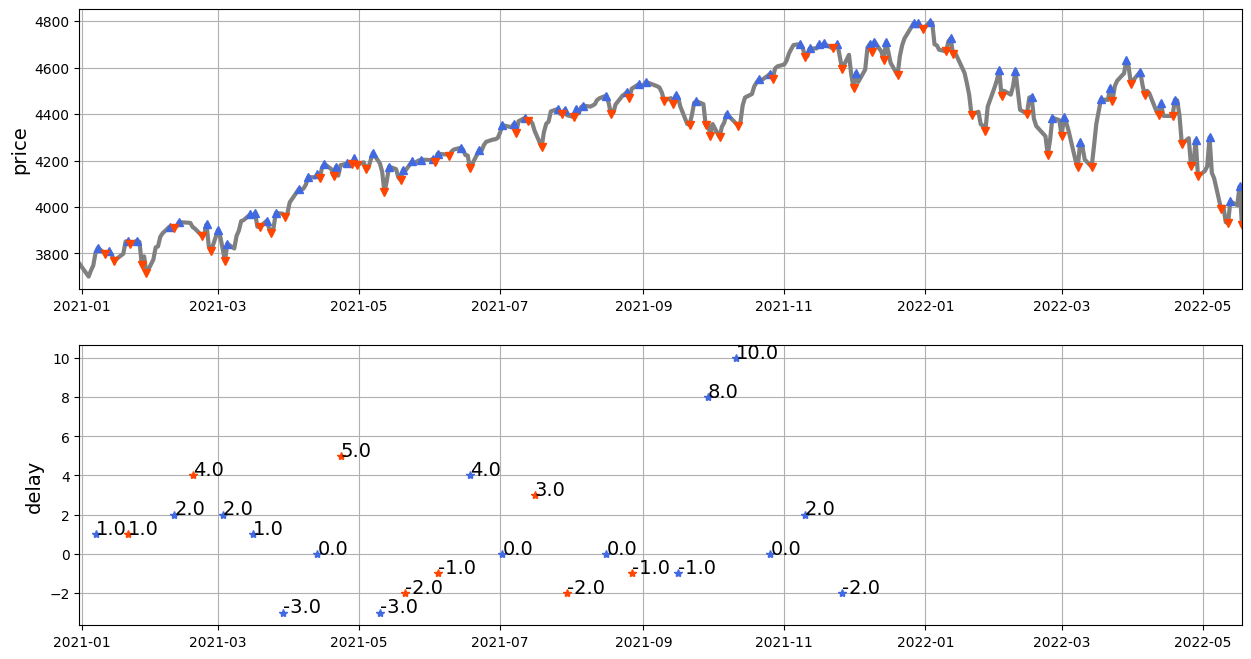

[0.9, 0.69, 0.51, 0.43, 0.32, 0.59, 0.36, 0.81, 0.65, 0.59, 0.75, 0.93, 0.53, 0.72, 0.86, 0.73, 0.84, 1.06, 0.64, 0.69, 0.73, 1.06, 1.15, 0.87]
[36, 38, 40, 40, 38, 32, 40, 34, 37, 37, 37, 36, 39, 34, 40, 25, 21, 33, 36, 40, 36, 25, 20, 34]
2.42
           delay       pv
Date                     
2021-01-07   1.0    peaks
2021-01-21   1.0  valleys
2021-02-10   2.0    peaks
2021-02-18   4.0  valleys
2021-03-03   2.0    peaks
2021-03-16   1.0    peaks
2021-03-29  -3.0    peaks
2021-04-13   0.0    peaks
2021-04-23   5.0  valleys
2021-05-10  -3.0    peaks
2021-05-21  -2.0  valleys
2021-06-04  -1.0  valleys
2021-06-18   4.0    peaks
2021-07-02   0.0    peaks
2021-07-16   3.0  valleys
2021-07-30  -2.0  valleys
2021-08-16   0.0    peaks
2021-08-27  -1.0  valleys
2021-09-16  -1.0    peaks
2021-09-29   8.0    peaks
2021-10-11  10.0    peaks
2021-10-26   0.0    peaks
2021-11-10   2.0    peaks
2021-11-26  -2.0    peaks


In [34]:
slide_abs_test = main_function_slide_fit_score_slide_range(
    stock="^GSPC",date_start='2021-01-01',data_range=6,
    slide_range=2,n_slide=24,pv_range=2,n_harm_0=20,n_harm_1=40,type='abs'
    )
print(slide_abs_test[2])
print(slide_abs_test[3])
print(slide_abs_test[4])
print(slide_abs_test[5])

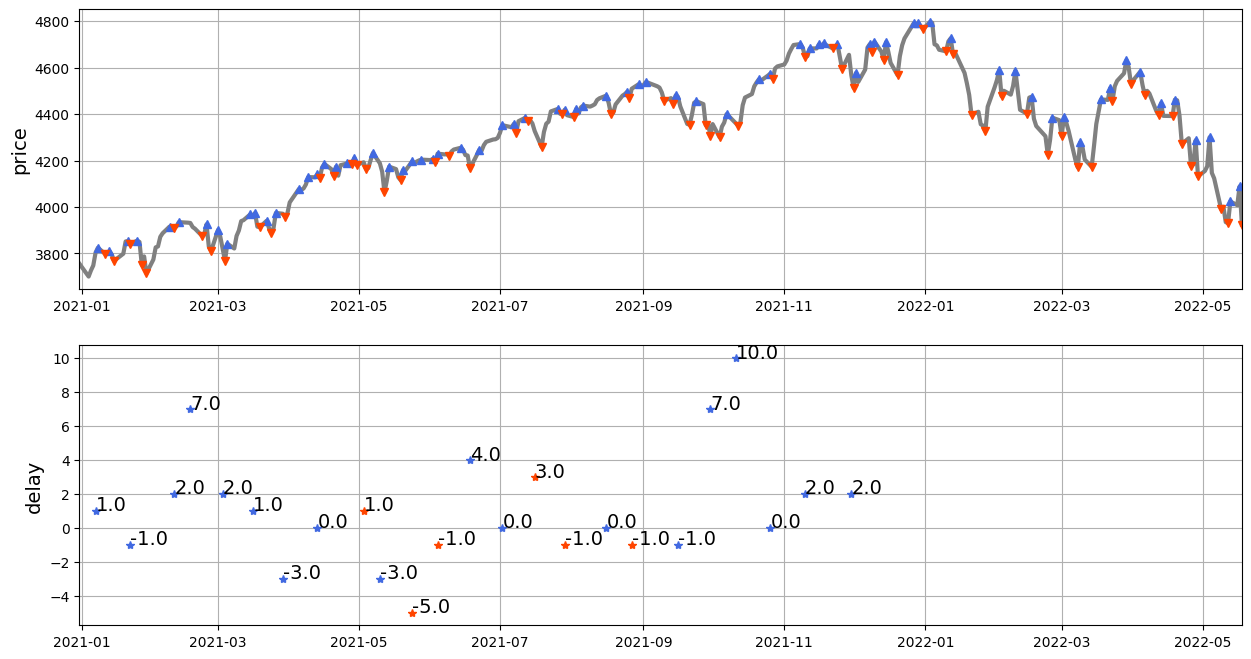

[0.07, 0.02, 0.07, 0.01, 0.01, 0.02, 0.01, 0.0, 0.04, 0.13, 0.04, 0.02, 0.01, 0.01, 0.17, 0.25, 0.01, -0.0, 0.0, -0.0, 0.1, -0.02, 0.01, 0.35]
[40, 22, 22, 31, 22, 36, 36, 36, 24, 37, 33, 21, 30, 38, 20, 20, 20, 37, 25, 33, 36, 25, 36, 20]
2.42
           delay       pv
Date                     
2021-01-07   1.0    peaks
2021-01-22  -1.0    peaks
2021-02-10   2.0    peaks
2021-02-17   7.0    peaks
2021-03-03   2.0    peaks
2021-03-16   1.0    peaks
2021-03-29  -3.0    peaks
2021-04-13   0.0    peaks
2021-05-03   1.0  valleys
2021-05-10  -3.0    peaks
2021-05-24  -5.0  valleys
2021-06-04  -1.0  valleys
2021-06-18   4.0    peaks
2021-07-02   0.0    peaks
2021-07-16   3.0  valleys
2021-07-29  -1.0  valleys
2021-08-16   0.0    peaks
2021-08-27  -1.0  valleys
2021-09-16  -1.0    peaks
2021-09-30   7.0    peaks
2021-10-11  10.0    peaks
2021-10-26   0.0    peaks
2021-11-10   2.0    peaks
2021-11-30   2.0    peaks


In [35]:
slide_mean_test = main_function_slide_fit_score_slide_range(
    stock="^GSPC",date_start='2021-01-01',data_range=6,
    slide_range=2,n_slide=24,pv_range=2,n_harm_0=20,n_harm_1=40,type='mean'
    )
print(slide_mean_test[2])
print(slide_mean_test[3])
print(slide_mean_test[4])
print(slide_mean_test[5])

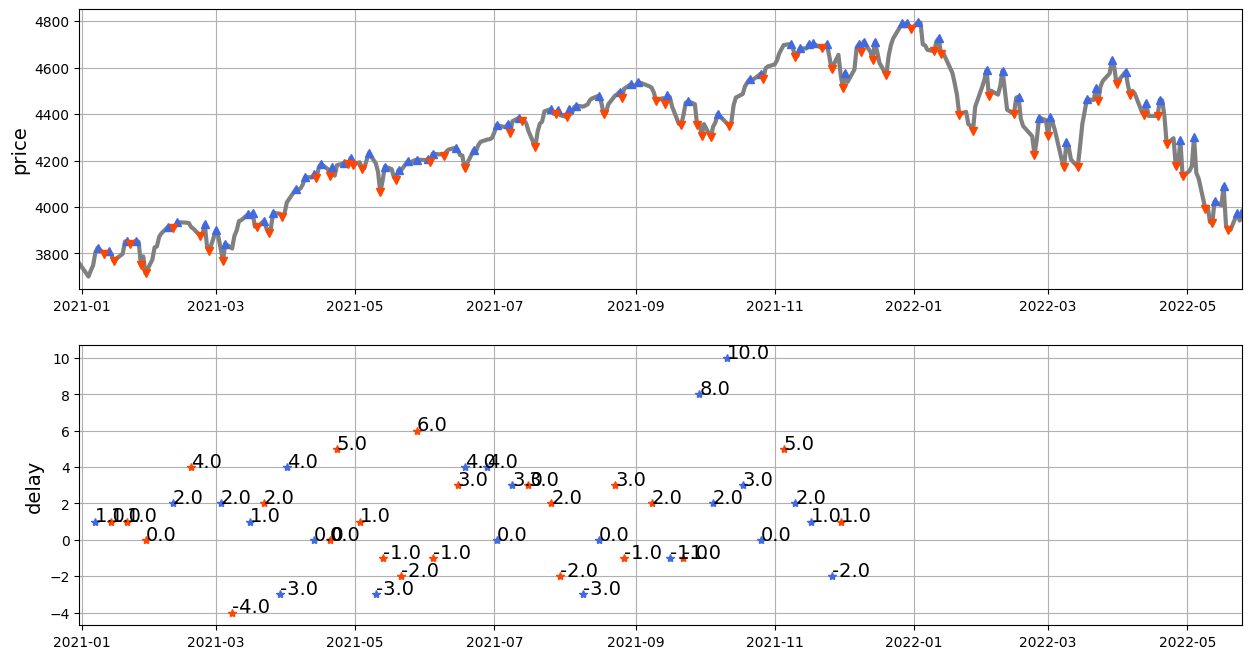

[0.9, 0.98, 0.69, 0.65, 0.51, 0.66, 0.43, 0.75, 0.32, 0.47, 0.59, 0.49, 0.36, 0.25, 0.81, 0.59, 0.65, 0.53, 0.59, 0.63, 0.75, 0.67, 0.93, 0.77, 0.53, 0.64, 0.72, 1.34, 0.86, 0.7, 0.73, 0.74, 0.84, 1.06, 1.06, 1.03, 0.64, 0.84, 0.69, 0.96, 0.73, 0.7, 1.06, 0.56, 1.15, 0.82, 0.87, 0.82]
[36, 34, 38, 40, 40, 40, 40, 37, 38, 39, 32, 37, 40, 38, 34, 39, 37, 36, 37, 40, 37, 39, 36, 38, 39, 35, 34, 35, 40, 39, 25, 40, 21, 33, 33, 39, 36, 36, 40, 23, 36, 32, 25, 40, 20, 33, 34, 34]
2.38
           delay      pv
Date                    
2021-01-07   1.0   peaks
2021-01-14   1.0  vallys
2021-01-21   1.0  vallys
2021-01-29   0.0  vallys
2021-02-10   2.0   peaks
2021-02-10   2.0   peaks
2021-02-18   4.0  vallys
2021-03-03   2.0   peaks
2021-03-03   2.0   peaks
2021-03-08  -4.0  vallys
2021-03-16   1.0   peaks
2021-03-22   2.0  vallys
2021-03-29  -3.0   peaks
2021-04-01   4.0   peaks
2021-04-13   0.0   peaks
2021-04-20   0.0  vallys
2021-04-23   5.0  vallys
2021-05-03   1.0  vallys
2021-05-10  -3.0

In [27]:
slide_abs_test_2 = main_function_slide_fit_score_slide_range(
    stock="^GSPC",date_start='2021-01-01',data_range=6,
    slide_range=1,n_slide=48,pv_range=2,n_harm_0=20,n_harm_1=40,type='abs'
    )
print(slide_abs_test_2[2])
print(slide_abs_test_2[3])
print(slide_abs_test_2[4])
print(slide_abs_test_2[5])

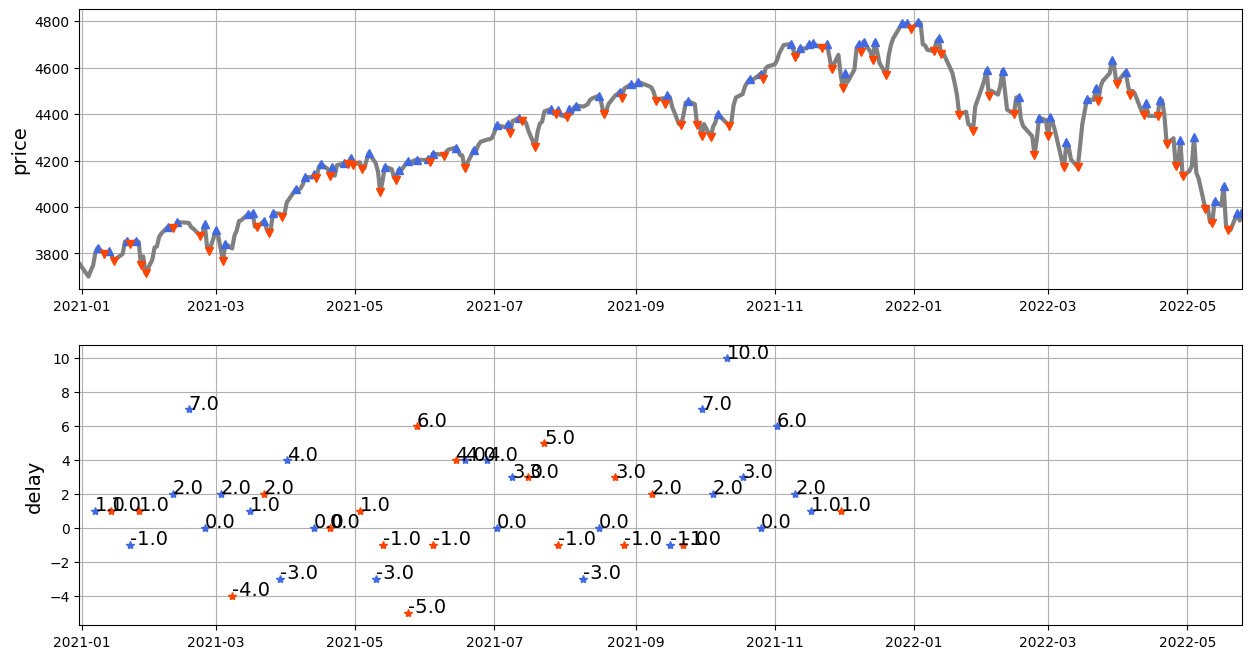

[0.07, 0.23, 0.02, -0.01, 0.07, 0.0, 0.01, 0.0, 0.01, -0.02, 0.02, -0.01, 0.01, 0.02, 0.0, 0.08, 0.04, -0.05, 0.13, 0.0, 0.04, 0.02, 0.02, 0.01, 0.01, -0.01, 0.01, -0.01, 0.17, 0.25, 0.25, -0.01, 0.01, -0.0, -0.0, -0.05, 0.0, 0.0, -0.0, 0.0, 0.1, -0.01, -0.02, 0.0, 0.01, -0.0, 0.35, 0.25]
[40, 34, 22, 22, 22, 25, 31, 33, 22, 38, 36, 28, 36, 40, 36, 21, 24, 23, 37, 38, 33, 36, 21, 26, 30, 33, 38, 38, 20, 30, 20, 25, 20, 30, 37, 40, 25, 39, 33, 30, 36, 33, 25, 21, 36, 21, 20, 35]
2.46
           delay      pv
Date                    
2021-01-07   1.0   peaks
2021-01-14   1.0  vallys
2021-01-22  -1.0   peaks
2021-01-26   1.0  vallys
2021-02-10   2.0   peaks
2021-02-10   2.0   peaks
2021-02-17   7.0   peaks
2021-02-24   0.0   peaks
2021-03-03   2.0   peaks
2021-03-08  -4.0  vallys
2021-03-16   1.0   peaks
2021-03-22   2.0  vallys
2021-03-29  -3.0   peaks
2021-04-01   4.0   peaks
2021-04-13   0.0   peaks
2021-04-20   0.0  vallys
2021-05-03   1.0  vallys
2021-05-03   1.0  vallys
2021-05-10  

In [28]:
slide_mean_test_2 = main_function_slide_fit_score_slide_range(
    stock="^GSPC",date_start='2021-01-01',data_range=6,
    slide_range=1,n_slide=48,pv_range=2,n_harm_0=20,n_harm_1=40,type='mean'
    )
print(slide_mean_test_2[2])
print(slide_mean_test_2[3])
print(slide_mean_test_2[4])
print(slide_mean_test_2[5])

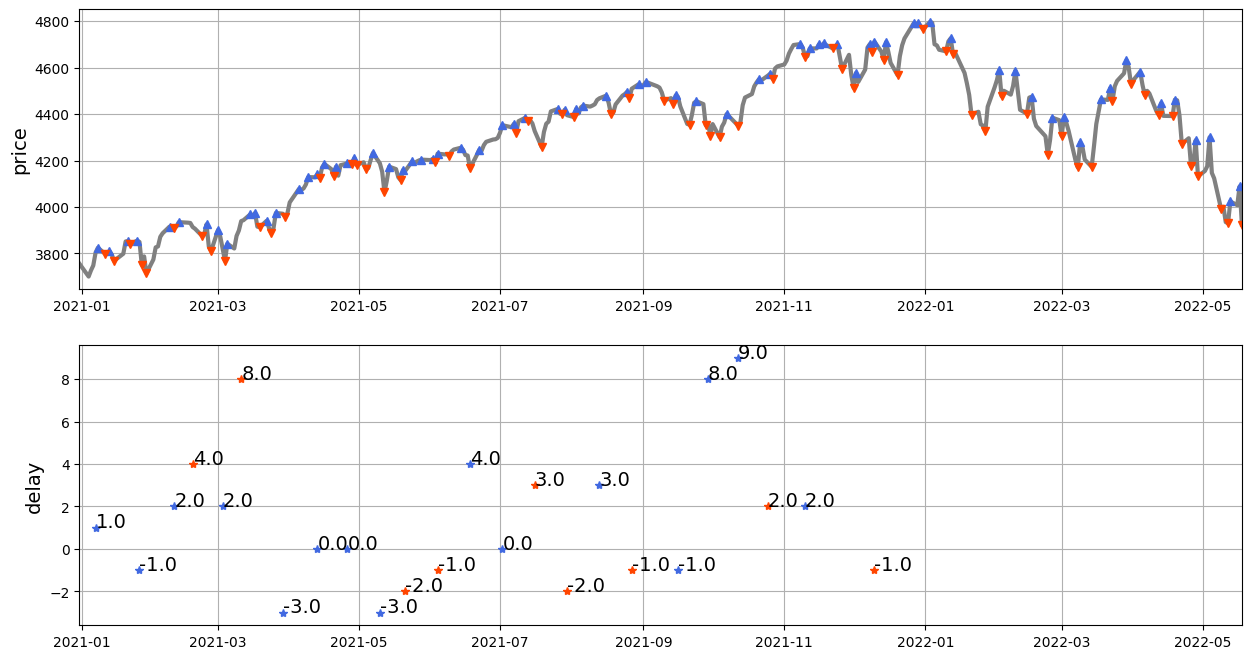

[0.9, 0.41, 0.26, 0.37, 0.22, 0.58, 0.14, 0.34, 0.45, 0.41, 0.43, 0.93, 0.53, 0.45, 0.66, 0.62, 0.75, 0.63, 0.64, 0.49, 0.47, 0.89, 1.06, 0.5]
[36, 45, 48, 41, 43, 50, 48, 51, 49, 42, 51, 36, 39, 49, 51, 47, 5, 51, 36, 51, 50, 48, 47, 3]
2.62
           delay      pv
Date                    
2021-01-07   1.0   peaks
2021-01-26  -1.0   peaks
2021-02-10   2.0   peaks
2021-02-18   4.0  vallys
2021-03-03   2.0   peaks
2021-03-11   8.0  vallys
2021-03-29  -3.0   peaks
2021-04-13   0.0   peaks
2021-04-26   0.0   peaks
2021-05-10  -3.0   peaks
2021-05-21  -2.0  vallys
2021-06-04  -1.0  vallys
2021-06-18   4.0   peaks
2021-07-02   0.0   peaks
2021-07-16   3.0  vallys
2021-07-30  -2.0  vallys
2021-08-13   3.0   peaks
2021-08-27  -1.0  vallys
2021-09-16  -1.0   peaks
2021-09-29   8.0   peaks
2021-10-12   9.0   peaks
2021-10-25   2.0  vallys
2021-11-10   2.0   peaks
2021-12-10  -1.0  vallys


In [29]:
slide_abs_test_3 = main_function_slide_fit_score_slide_range(
    stock="^GSPC",date_start='2021-01-01',data_range=6,
    slide_range=2,n_slide=24,pv_range=2,n_harm_0=0,n_harm_1=60,type='abs'
    )
print(slide_abs_test_3[2])
print(slide_abs_test_3[3])
print(slide_abs_test_3[4])
print(slide_abs_test_3[5])

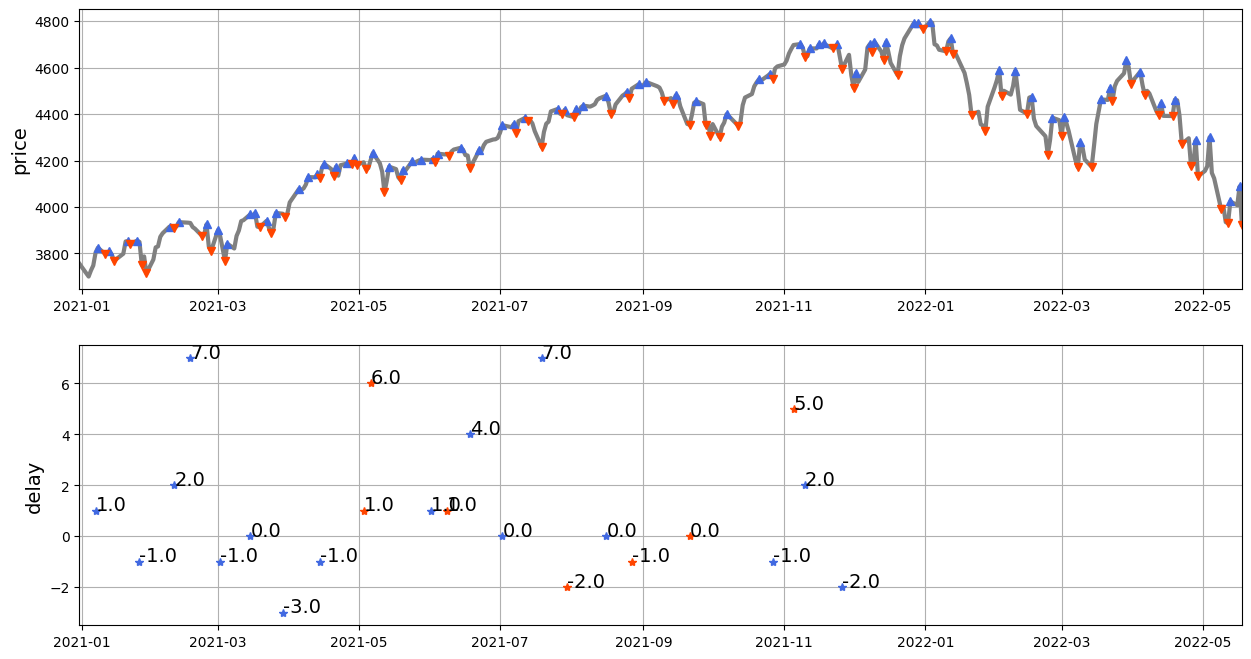

[0.07, -0.0, 0.0, 0.01, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.01, -0.05, 0.06, 0.01, -0.0, 0.0, 0.0, 0.0, 0.0, -0.0, 0.09]
[40, 44, 48, 31, 1, 5, 41, 3, 8, 5, 5, 1, 50, 38, 9, 13, 20, 37, 2, 2, 1, 1, 17, 51]
2.25
           delay      pv
Date                    
2021-01-07   1.0   peaks
2021-01-26  -1.0   peaks
2021-02-10   2.0   peaks
2021-02-17   7.0   peaks
2021-03-02  -1.0   peaks
2021-03-15   0.0   peaks
2021-03-29  -3.0   peaks
2021-04-14  -1.0   peaks
2021-05-03   1.0  vallys
2021-05-06   6.0  vallys
2021-06-01   1.0   peaks
2021-06-08   1.0  vallys
2021-06-18   4.0   peaks
2021-07-02   0.0   peaks
2021-07-19   7.0   peaks
2021-07-30  -2.0  vallys
2021-08-16   0.0   peaks
2021-08-27  -1.0  vallys
2021-09-21   0.0  vallys
2021-10-27  -1.0   peaks
2021-11-05   5.0  vallys
2021-11-05   5.0  vallys
2021-11-10   2.0   peaks
2021-11-26  -2.0   peaks


In [30]:
slide_mean_test_3 = main_function_slide_fit_score_slide_range(
    stock="^GSPC",date_start='2021-01-01',data_range=6,
    slide_range=2,n_slide=24,pv_range=2,n_harm_0=0,n_harm_1=60,type='mean'
    )
print(slide_mean_test_3[2])
print(slide_mean_test_3[3])
print(slide_mean_test_3[4])
print(slide_mean_test_3[5])